<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Relevant-imports" data-toc-modified-id="Relevant-imports-1">Relevant imports</a></span></li><li><span><a href="#Useful-datasets" data-toc-modified-id="Useful-datasets-2">Useful datasets</a></span></li><li><span><a href="#Food-deserts" data-toc-modified-id="Food-deserts-3">Food deserts</a></span><ul class="toc-item"><li><span><a href="#Grocery-stores-density" data-toc-modified-id="Grocery-stores-density-3.1">Grocery stores density</a></span></li><li><span><a href="#Community-areas-by-ethnicity" data-toc-modified-id="Community-areas-by-ethnicity-3.2">Community areas by ethnicity</a></span><ul class="toc-item"><li><span><a href="#Proportion-of-ethnicities-in-the-city-of-Chicago" data-toc-modified-id="Proportion-of-ethnicities-in-the-city-of-Chicago-3.2.1">Proportion of ethnicities in the city of Chicago</a></span></li></ul></li><li><span><a href="#Diet-related-diseases" data-toc-modified-id="Diet-related-diseases-3.3">Diet-related diseases</a></span><ul class="toc-item"><li><span><a href="#Diabetes-related-deaths" data-toc-modified-id="Diabetes-related-deaths-3.3.1">Diabetes related deaths</a></span><ul class="toc-item"><li><span><a href="#Diabetes-related-deaths-against-to-grocery-stores-density" data-toc-modified-id="Diabetes-related-deaths-against-to-grocery-stores-density-3.3.1.1">Diabetes related deaths against to grocery stores density</a></span></li><li><span><a href="#Diabetes-related-deaths-visualized-on-a-map" data-toc-modified-id="Diabetes-related-deaths-visualized-on-a-map-3.3.1.2">Diabetes related deaths visualized on a map</a></span></li></ul></li><li><span><a href="#Colorectal-Cancer-related-deaths" data-toc-modified-id="Colorectal-Cancer-related-deaths-3.3.2">Colorectal Cancer related deaths</a></span><ul class="toc-item"><li><span><a href="#Colorectal-Cancer-related-deaths-against-to-grocery-stores-density" data-toc-modified-id="Colorectal-Cancer-related-deaths-against-to-grocery-stores-density-3.3.2.1">Colorectal Cancer related deaths against to grocery stores density</a></span></li><li><span><a href="#Colorectal-Cancer-related-deaths-visualized-on-a-map" data-toc-modified-id="Colorectal-Cancer-related-deaths-visualized-on-a-map-3.3.2.2">Colorectal Cancer related deaths visualized on a map</a></span></li></ul></li><li><span><a href="#Stroke" data-toc-modified-id="Stroke-3.3.3">Stroke</a></span><ul class="toc-item"><li><span><a href="#Stroke-related-deaths-visualized-on-a-map" data-toc-modified-id="Stroke-related-deaths-visualized-on-a-map-3.3.3.1">Stroke related deaths visualized on a map</a></span></li></ul></li></ul></li><li><span><a href="#Is-grocery-stores-density-influenced-by-the-purchasing-power-of-the-community-area?" data-toc-modified-id="Is-grocery-stores-density-influenced-by-the-purchasing-power-of-the-community-area?-3.4">Is grocery stores density influenced by the purchasing power of the community area?</a></span></li></ul></li><li><span><a href="#Data-Science-for-social-good" data-toc-modified-id="Data-Science-for-social-good-4">Data Science for social good</a></span></li></ul></div>

# Relevant imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import math
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

import datetime

from autocorrect import Speller

from datetime import date as dt

from sklearn.linear_model import LinearRegression

import folium
from folium import plugins
from folium.plugins import HeatMap
import geopandas as gpd

import geopandas as gpd
from shapely.geometry import shape, Point

import requests
from pandas.io.json import json_normalize
import pandas_profiling

import warnings
warnings.filterwarnings('ignore')

from bokeh.io import curdoc, output_notebook
from bokeh.models import Slider, HoverTool
from bokeh.layouts import widgetbox, row, column

# Useful datasets

In [2]:
socioeconomic_factors = pd.read_csv("datasets/cleaned_socioeconomic_factors.csv")
inspections = pd.read_csv("datasets/cleaned_inspections.csv")
fp = "datasets/boundaries_processed.geojson"
boundaries_community_areas = gpd.read_file(fp)
inspections.loc[:,('Inspection Date')]=inspections.loc[:,('Inspection Date')].apply(pd.to_datetime)

# Food deserts

**Context:**

After a small research, we found out about a problem affecting public health in Chicago at a large scale called **Food deserts**. In a report by the Illinois Advisory Committee to the United States Commission on Civil Rights, it is reported that some of the community areas in Chicago are lacking supermarkets, grocery stores and healthy food in general. Restricted access to healthy foods lead to higher rates of chronic illness like diabetes, hypertension, or cardiovascular disease. [source](https://www.usccr.gov/pubs/docs/IL-FoodDeserts-2011.pdf)

Furthermore, it is stated in the report that these food desert neighborhoods are almost exclusively in African American neighborhoods making the issue a civil rights one beyond its public health dimension.

**In the next part we will try to see if we can visualize the food deserts using the food inspection dataset**

**Approach to the problem**

* We first try to look at establishments that represent healthy food providers (grocery store, farmer's market, fish market, meat market, etc). These establishments also have inspections and so we retrieve them from our dataset and plot their intensity by 1'000 habitants for the different community areas.

* We then try to visualize on a map the most common ethnicity accross all community areas as well as some socio economic factors.

* In the end we will show diet related disease rates by community area as well and try to see how it relates.

## Grocery stores density

In [3]:
#We care about grocery stores only
groceries_intensity = inspections[inspections['Facility Type']=='Market']
groceries_intensity = groceries_intensity[groceries_intensity['Inspection Date'].dt.year==2018]
groceries_intensity = groceries_intensity[['Community Area','DBA Name','area_number']].drop_duplicates().groupby(['Community Area','area_number'])['DBA Name'].agg({'nbr_markets' : len})
groceries_intensity.reset_index(inplace=True)

The distribution of healthy food should be equal in terms of grocery stores by square meter for all community areas. This is the essence of the problem as described in the [wikipedia page concerning Supermarket shartage in the USA](https://en.wikipedia.org/wiki/Supermarket_shortage). The unequal distribution leads people to take long distance rides to have access to fresh food and the public transportation system is usually also bad for those areas.

**For the next part we plot the grocery stores densty per community area to see if any patterns emerge**

In [4]:
population_by_community = socioeconomic_factors[['Community Area','Population']]
groceries_intensity = groceries_intensity.merge(population_by_community,\
                              left_on='area_number', right_on='Community Area')

groceries_intensity = groceries_intensity.merge(boundaries_community_areas,\
                              left_on='area_number', right_on='area_number')



groceries_intensity['markets_by_surface'] = groceries_intensity['nbr_markets'].div(groceries_intensity['shape_area'].values,axis=0)
min_value, max_value = np.min(groceries_intensity['markets_by_surface']), np.max(groceries_intensity['markets_by_surface'])

groceries_intensity['markets_by_surface']=(groceries_intensity['markets_by_surface']-min_value)/max_value

groceries_intensity.drop(columns=['Community Area_y', 'community'], inplace=True)
groceries_intensity.rename(columns={'Community Area_x':'Community Area'}, inplace=True)

In [5]:
# Initialize the map:
groceries_by_community = folium.Map([41.84, -87.7099], zoom_start=10, tiles = "cartodbpositron")
         
# Add the color for the chloropleth:
groceries_by_community.choropleth(
     geo_data=fp,
     name='Grocery Stores Density',
     data=groceries_intensity,
     columns=['Community Area', 'markets_by_surface'],
     key_on='feature.properties.community',
     fill_color='YlGnBu', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Grocery Stores Density',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(groceries_intensity,\
                              left_on=['area_number','community','geometry','shape_area'], \
                                     right_on=['area_number','Community Area','geometry','shape_area'])
x['Population']=(np.round(x['Population']/1000)).astype(int)

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'black',
        'color': 'black',
        'weight': 0.3,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community', 'nbr_markets','Population'],
        aliases=['Community Area', 'Number of Grocery Stores','Population Count (in thousands)'],
    ),
).add_to(groceries_by_community)

# Save to html
groceries_by_community.save('./groceries_by_community.html')

The map can be accessed [here](https://aaag97.github.io/ada-2019-project-databusters/groceries_by_community.html)

**"Chicago’s segregation is certainly legendary, with the North and South sides divided by class and race. To keep it stereotypically simple: The North Side is white, the South Side is black."**[source](https://chicago.eater.com/2018/12/13/18138387/chicago-magazine-john-kessler-food-scene-racism-immigration-food)

We certainly see a difference in the concentration of grocery stores between the North and the South, the south being quite sparse.

**Let's see if we can visualize the different ethnicities on the map to support the claim that the south is Black and the noth is White**

## Community areas by ethnicity

Data set [source](https://www.chicagohealthatlas.org/indicators/non-hispanic-white)

In [6]:
latino = pd.read_excel('datasets/Hispanic_or_Latino_population.xlsx')
black = pd.read_excel('datasets/Non-Hispanic_African-Amercian_or_Black_population.xlsx')
asian = pd.read_excel('datasets/Non-Hispanic_Asian_or_Pacific_Islander_population.xlsx')
white = pd.read_excel('datasets/Non-Hispanic_White_population.xlsx')

In [7]:
def preprocess_ethnicity(df):
    df = df\
                        .drop(columns =['Category', 'SubCategory', 'Geo_ID', 'Demography', 'Demo_Group', 
                                        'Cum_Number', 'Ave_Annual_Number', 'Crude_Rate', 'Lower_95CI_Crude_Rate', 
                                        'Upper_95CI_Crude_Rate', 'Age_Adj_Rate', 'Lower_95CI_Age_Adj_Rate', 
                                        'Upper_95CI_Age_Adj_Rate', 'Percent', 'Lower_95CI_Percent', 'Indicator',
                                        'Upper_95CI_Percent', 'Weight_Number', 'Weight_Percent', 'Geography',
                                        'Lower_95CI_Weight_Percent','Upper_95CI_Weight_Percent', 'Map_Key', 'Flag'])
    df = df[df['Year']=='2012-2016'].reset_index()
    df = df.drop(columns='index')
    df['Community Area'] = [df.Geo_Group[i].split('-', 1)[0] for i in range(len(df))] 
    df['Community Area Name'] = [df.Geo_Group[i].split('-', 1)[1] for i in range(len(df))] 
    df = df.drop(columns=['Geo_Group','Year'])
    df = df[['Community Area', 'Community Area Name', 'Number']]
    df['Community Area'] = df['Community Area'].astype(int)
    return df

In [8]:
latino = preprocess_ethnicity(latino)
black = preprocess_ethnicity(black)
asian = preprocess_ethnicity(asian)
white = preprocess_ethnicity(white)[:77]

In [9]:
white.rename(columns={'Number':'Number_White'}, inplace=True)
latino.rename(columns={'Number':'Number_Latino'}, inplace=True)
black.rename(columns={'Number':'Number_Black'}, inplace=True)
asian.rename(columns={'Number':'Number_Asian'}, inplace=True)

In [10]:
ethnicity_by_community = white
ethnicity_by_community['Number_Latino'] = latino['Number_Latino']
ethnicity_by_community['Number_Black'] = black['Number_Black']
ethnicity_by_community['Number_Asian'] = asian['Number_Asian']

In [11]:
ethnicity_by_community.to_csv("datasets/ethnicity_by_community.csv",index=False)

### Proportion of ethnicities in the city of Chicago

**Let's break down the population by ethnicity**
For the purpose of supporting our claims using data, we look at the community areas by their majority ethnicity. Even though Chicago's population is divided in three almost equal proportions of Black, White and Latino people, with a minority of Asians, we clearly  see a separation between the North and the South, the South being majoritarily Black, the North White and the West Latino. Looking closely you can even notice that a great number of the community areas have very high rates of a single ethnicity.

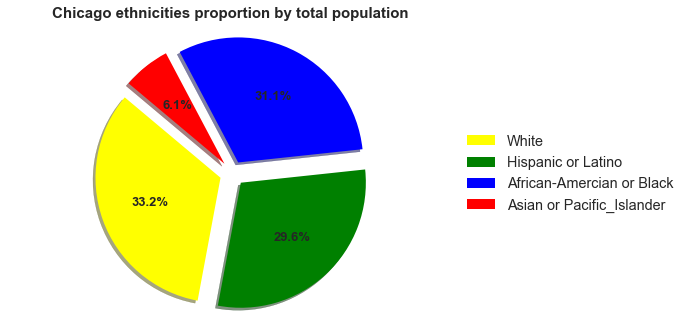

In [12]:
sum_ethnicity = list(ethnicity_by_community.sum(axis=0)[['Number_White','Number_Latino','Number_Black','Number_Asian']])

# Data to plot

fig, ax = plt.subplots( subplot_kw=dict(aspect="equal"))

labels = 'White', 'Hispanic or Latino', 'African-Amercian or Black', 'Asian or Pacific_Islander'
sizes = sum_ethnicity
colors = ['yellow','green','blue','red']
explode = (0.1, 0.1, 0.1, 0.1)  # explode 1st slice

# Plot
wedges, texts, autotexts = plt.pie(sizes, explode=explode, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.setp(autotexts, size=13, weight="bold")

plt.setp(texts, size=13, weight="bold")

ax.legend(wedges, labels,
          #title="Ethnicities",
          loc="center left",
          fontsize = 'x-large',
          bbox_to_anchor=(1, 0, 0.5, 1))

ax.set_title("Chicago ethnicities proportion by total population", size=15, weight="bold")

plt.axis('equal')
plt.show()

In [13]:
ethnicity_by_community['Population'] = ethnicity_by_community[['Number_White','Number_Latino','Number_Black','Number_Asian']].sum(axis=1)
majority = np.argmax(np.array(ethnicity_by_community[['Number_White','Number_Latino','Number_Black','Number_Asian']]),axis=1)
ethnicity_by_community['Majority'] = majority
ethnicity_by_community['proportion_white']=np.round(ethnicity_by_community['Number_White'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_black']=np.round(ethnicity_by_community['Number_Black'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_asian']=np.round(ethnicity_by_community['Number_Asian'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')
ethnicity_by_community['proportion_latino']=np.round(ethnicity_by_community['Number_Latino'].div(ethnicity_by_community['Population'].values,axis=0)*100).astype('int')

In [14]:
# Initialize the map:
ethnicity_map = folium.Map([41.84, -87.7099], zoom_start=10.5, tiles = "cartodbpositron")
         
x = boundaries_community_areas.merge(ethnicity_by_community,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    style_function=lambda feature: {
        'fillColor': 'yellow' if feature['properties']['Majority'] ==0 \
                                else 'green' if feature['properties']['Majority'] ==1\
                                else 'blue' if feature['properties']['Majority'] ==2\
                                else 'red',
        'fillOpacity':0.5,
        'color': 'black',
        'weight': 0.4
        #'dashArray': '5, 5'
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','proportion_black','proportion_white','proportion_asian','proportion_latino'],
        aliases=['Community Area','Percentage of Black','Percentage of White','Percentage of Asians','Percentage of Latinos'],
    ),
).add_to(ethnicity_map)


# Save to html
ethnicity_map.save('./ethnicity_map.html')


## Diet-related diseases

* The problem of supermarket shortage as described on several sources, is highly correlated to the fact that diet-related diseases (cancer, obesity, and diabetes) are a lot more common in the areas with restricted access to healthy food.
* We will try to visualize if there is a correlation between the number of deaths by those diet-related disease and the grocery stores density in each community area.

In [15]:
# We will only keep community areas which have high proportions of a single ethnicity to reduce noice in our dataset.
areas_white = [5,6,7,8,9,10,11,32,74,76]
areas_black = [25,26,27,29,36,37,38,40,42,43,44,45,47,48,49,50,53,54,67,68,69,71,73]
areas_latino = [18,19,30,31,52,58,63,63,65]
areas_to_analize = areas_white+areas_black+areas_latino

### Diabetes related deaths

#### Diabetes related deaths against to grocery stores density

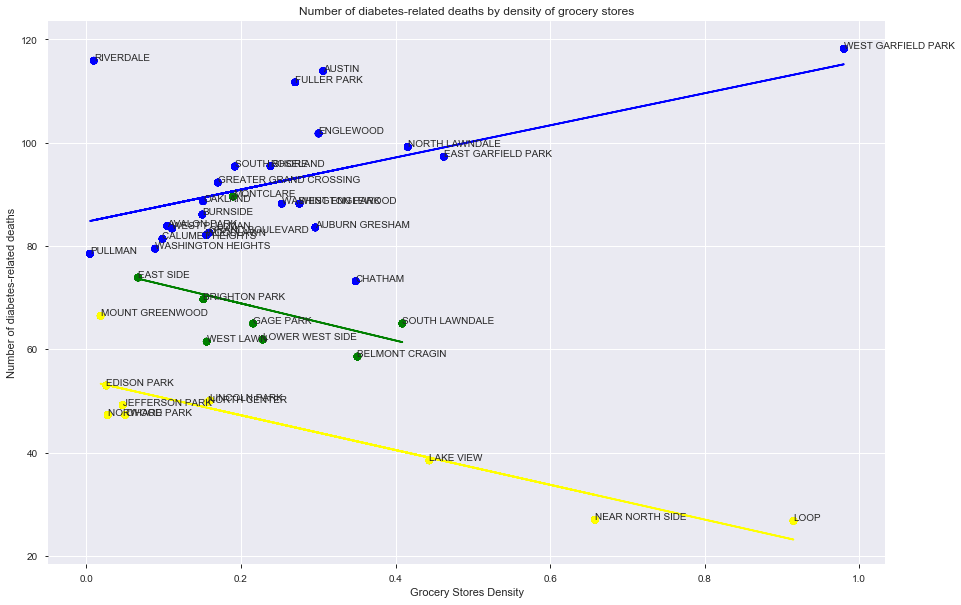

In [16]:
fig, ax = plt.subplots(figsize=(15,10))
colors = ethnicity_by_community[ethnicity_by_community['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
colors = np.array(colors['Majority'].replace({0 : 'yellow', 1 : 'green', 2 : 'blue', 3 : 'red'}))

ys = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
ys = np.array(ys['Diabetes-related'])

xs = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
xs = np.array(xs['markets_by_surface'])

labels = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
labels = np.array(labels['Community Area'])

plt.title('Number of diabetes-related deaths by density of grocery stores')
plt.xlabel('Grocery Stores Density')
plt.ylabel('Number of diabetes-related deaths')


white_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_white)].sort_values(by='area_number', ascending=True)
white_x = np.array(white_x['markets_by_surface'])
white_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_white)].sort_values(by='Community Area', ascending=True)
white_y = np.array(white_y['Diabetes-related'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(white_x.reshape(-1,1), white_y.reshape(-1,1))  # perform linear regression
y_pred_white = linear_regressor.predict(white_x.reshape(-1,1))  # make predictions


black_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_black)].sort_values(by='area_number', ascending=True)
black_x = np.array(black_x['markets_by_surface'])
black_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_black)].sort_values(by='Community Area', ascending=True)
black_y = np.array(black_y['Diabetes-related'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(black_x.reshape(-1,1), black_y.reshape(-1,1))  # perform linear regression
y_pred_black = linear_regressor.predict(black_x.reshape(-1,1))  # make predictions

latino_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_latino)].sort_values(by='area_number', ascending=True)
latino_x = np.array(latino_x['markets_by_surface'])
latino_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_latino)].sort_values(by='Community Area', ascending=True)
latino_y = np.array(latino_y['Diabetes-related'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(latino_x.reshape(-1,1), latino_y.reshape(-1,1))  # perform linear regression
y_pred_latino = linear_regressor.predict(latino_x.reshape(-1,1))  # make predictions

i=0
for x, y, c in zip(xs,ys,colors):
    ax.scatter(xs, ys, color=colors)
    ax.annotate(labels[i], (x, y))
    i+=1
plt.plot(white_x, y_pred_white, color='yellow')
plt.plot(black_x, y_pred_black, color='blue')
plt.plot(latino_x, y_pred_latino, color='green')

* As a first step, we saw that there were inherent clusters emerging in our scatter plot. So we added the colors representing ethnicities and discovered that each ethnicity was at a different rate of "diabetes-related deaths".
* This makes sence as after a small research we saw that national statistics in the USA already show that rates of diabetes are different from a race to another [source](https://www.diabetes.org/resources/statistics/statistics-about-diabetes)
* Hence we to avoid [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox), we try to fit a linear regression to every race to see if for the same given race, the diabetes related deaths could drop if there are more grocery stores.
* We were disappointed to see that our analysis doesn't give us meaningful results. Our hypothesis for that is maybe diabetes-related deaths is not a good enough indicator, "diabetes rates" would have been a better one but such a dataset is not available. Also, there are surely a lot of other factors that influence diabetes deaths rate, so an accurate model would have to take all of those factors into consideration. Our other hypothesis is that the grocery stores density is not accurate enough, it's just an approximation because it could happen that a grocery store do not get inspected. 

#### Diabetes related deaths visualized on a map

In [17]:
# Initialize the map:
diabetes_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
diabetes_map.choropleth(
     geo_data=fp,
     name='Diabetes_related_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Diabetes-related'],
     key_on='feature.properties.area_number',
     fill_color='YlOrBr', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Diabetes related mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Diabetes-related'],
        aliases=['Community Area','Number of Diabetes related deaths'],
    ),
).add_to(diabetes_map)

# Save to html
diabetes_map.save('./diabetes_mortality.html')

The map can be accessed [here](https://aaag97.github.io/ada-2019-project-databusters/diabetes_mortality.html)

### Colorectal Cancer related deaths

#### Colorectal Cancer related deaths against to grocery stores density

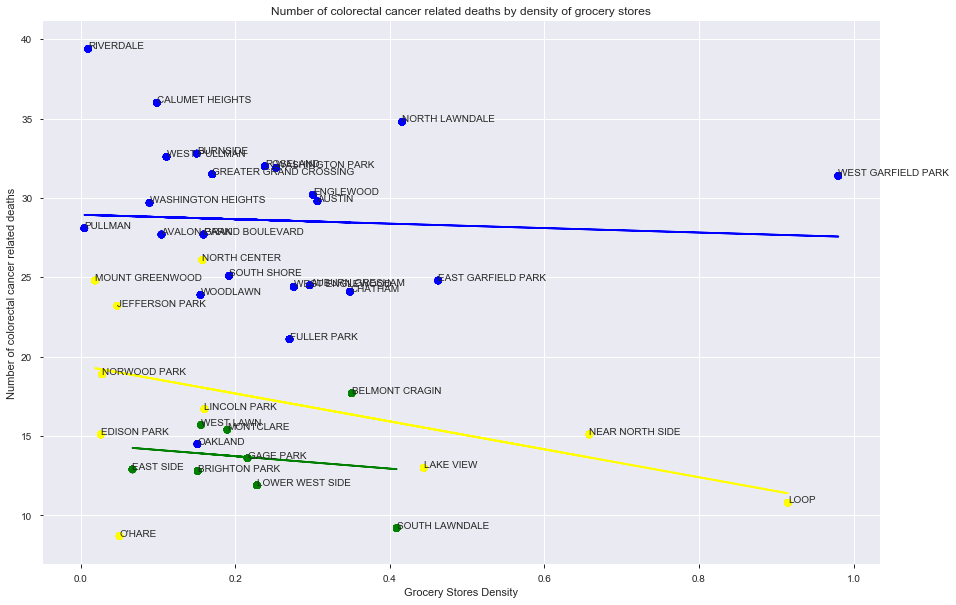

In [18]:
fig, ax = plt.subplots(figsize=(15,10))
colors = ethnicity_by_community[ethnicity_by_community['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
colors = np.array(colors['Majority'].replace({0 : 'yellow', 1 : 'green', 2 : 'blue', 3 : 'red'}))

ys = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
ys = np.array(ys['Colorectal Cancer'])

xs = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
xs = np.array(xs['markets_by_surface'])

labels = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
labels = np.array(labels['Community Area'])

plt.title('Number of colorectal cancer related deaths by density of grocery stores')
plt.xlabel('Grocery Stores Density')
plt.ylabel('Number of colorectal cancer related deaths')


white_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_white)].sort_values(by='area_number', ascending=True)
white_x = np.array(white_x['markets_by_surface'])
white_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_white)].sort_values(by='Community Area', ascending=True)
white_y = np.array(white_y['Colorectal Cancer'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(white_x.reshape(-1,1), white_y.reshape(-1,1))  # perform linear regression
y_pred_white = linear_regressor.predict(white_x.reshape(-1,1))  # make predictions


black_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_black)].sort_values(by='area_number', ascending=True)
black_x = np.array(black_x['markets_by_surface'])
black_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_black)].sort_values(by='Community Area', ascending=True)
black_y = np.array(black_y['Colorectal Cancer'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(black_x.reshape(-1,1), black_y.reshape(-1,1))  # perform linear regression
y_pred_black = linear_regressor.predict(black_x.reshape(-1,1))  # make predictions

latino_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_latino)].sort_values(by='area_number', ascending=True)
latino_x = np.array(latino_x['markets_by_surface'])
latino_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_latino)].sort_values(by='Community Area', ascending=True)
latino_y = np.array(latino_y['Colorectal Cancer'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(latino_x.reshape(-1,1), latino_y.reshape(-1,1))  # perform linear regression
y_pred_latino = linear_regressor.predict(latino_x.reshape(-1,1))  # make predictions

i=0
for x, y, c in zip(xs,ys,colors):
    ax.scatter(xs, ys, color=colors)
    ax.annotate(labels[i], (x, y))
    i+=1
plt.plot(white_x, y_pred_white, color='yellow')
plt.plot(black_x, y_pred_black, color='blue')
plt.plot(latino_x, y_pred_latino, color='green')

* The results we get from the colorectal canceer are a bit more convincing but it still looks like our data is quite noisy.

#### Colorectal Cancer related deaths visualized on a map

In [19]:
# Initialize the map:
colorectal_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
colorectal_map.choropleth(
     geo_data=fp,
     name='colorectal_cancer_related_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Colorectal Cancer'],
     key_on='feature.properties.area_number',
     fill_color='YlOrRd', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Colorectal cancer related mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'red',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Colorectal Cancer'],
        aliases=['Community Area','Number of Colorectal Cancer related deaths'],
    ),
).add_to(colorectal_map)

# Save to html
colorectal_map.save('./colorectal_map.html')

The map can be accessed [here](https://aaag97.github.io/ada-2019-project-databusters/colorectal_map.html)

### Stroke

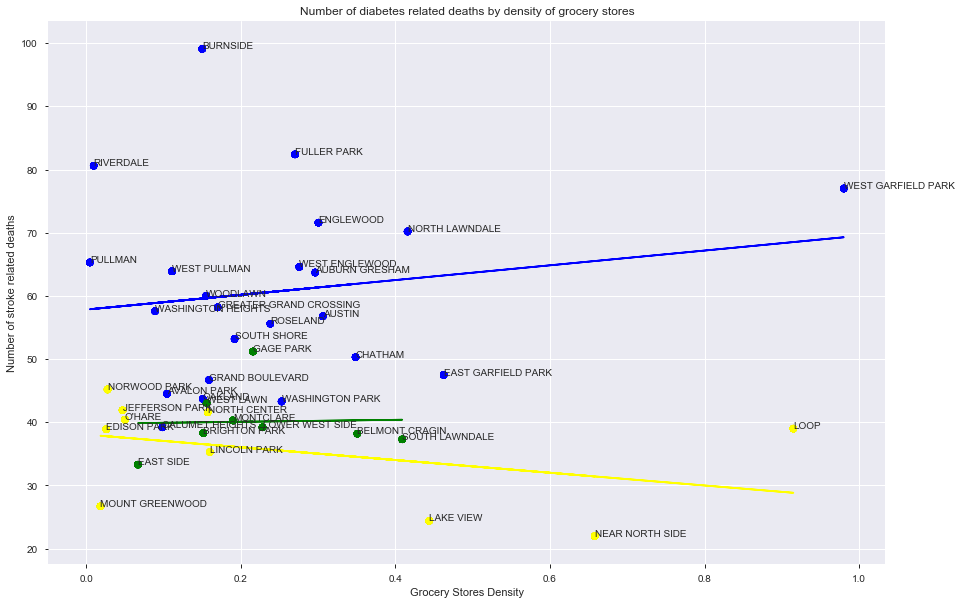

In [20]:
fig, ax = plt.subplots(figsize=(15,10))
colors = ethnicity_by_community[ethnicity_by_community['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
colors = np.array(colors['Majority'].replace({0 : 'yellow', 1 : 'green', 2 : 'blue', 3 : 'red'}))

ys = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_to_analize)].sort_values(by='Community Area', ascending=True)
ys = np.array(ys['Stroke (Cerebrovascular Disease)'])

xs = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
xs = np.array(xs['markets_by_surface'])

labels = groceries_intensity[groceries_intensity['area_number'].isin(areas_to_analize)].sort_values(by='area_number', ascending=True)
labels = np.array(labels['Community Area'])

plt.title('Number of diabetes related deaths by density of grocery stores')
plt.xlabel('Grocery Stores Density')
plt.ylabel('Number of stroke related deaths')


white_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_white)].sort_values(by='area_number', ascending=True)
white_x = np.array(white_x['markets_by_surface'])
white_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_white)].sort_values(by='Community Area', ascending=True)
white_y = np.array(white_y['Stroke (Cerebrovascular Disease)'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(white_x.reshape(-1,1), white_y.reshape(-1,1))  # perform linear regression
y_pred_white = linear_regressor.predict(white_x.reshape(-1,1))  # make predictions


black_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_black)].sort_values(by='area_number', ascending=True)
black_x = np.array(black_x['markets_by_surface'])
black_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_black)].sort_values(by='Community Area', ascending=True)
black_y = np.array(black_y['Stroke (Cerebrovascular Disease)'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(black_x.reshape(-1,1), black_y.reshape(-1,1))  # perform linear regression
y_pred_black = linear_regressor.predict(black_x.reshape(-1,1))  # make predictions

latino_x = groceries_intensity[groceries_intensity['area_number'].isin(areas_latino)].sort_values(by='area_number', ascending=True)
latino_x = np.array(latino_x['markets_by_surface'])
latino_y = socioeconomic_factors[socioeconomic_factors['Community Area'].isin(areas_latino)].sort_values(by='Community Area', ascending=True)
latino_y = np.array(latino_y['Stroke (Cerebrovascular Disease)'])
linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(latino_x.reshape(-1,1), latino_y.reshape(-1,1))  # perform linear regression
y_pred_latino = linear_regressor.predict(latino_x.reshape(-1,1))  # make predictions

i=0
for x, y, c in zip(xs,ys,colors):
    ax.scatter(xs, ys, color=colors)
    ax.annotate(labels[i], (x, y))
    i+=1
plt.plot(white_x, y_pred_white, color='yellow')
plt.plot(black_x, y_pred_black, color='blue')
plt.plot(latino_x, y_pred_latino, color='green')

#### Stroke related deaths visualized on a map

In [21]:
# Initialize the map:
stroke_map = folium.Map([41.84, -87.7099], zoom_start=10.5)
         
# Add the color for the chloropleth:
stroke_map.choropleth(
     geo_data=fp,
     name='stroke_mortality',
     data=socioeconomic_factors,
     columns=['Community Area', 'Stroke (Cerebrovascular Disease)'],
     key_on='feature.properties.area_number',
     fill_color='BuPu', fill_opacity=0.7, line_opacity=0.3,
     legend_name='Stroke mortality per 100,000 persons',
     highlight=True,
)   

# This is used to be able to render the tooltip -> folium is not really flexible in that sense
x = boundaries_community_areas.merge(socioeconomic_factors,\
                              left_on=['area_number'], \
                                     right_on=['Community Area'])

folium.GeoJson(
    x,
    name='community',
    show=True,
    style_function=lambda x: {
        'fillColor': 'black',
        'color': 'black',
        'weight': 1,
        'fillOpacity':0
    },
    highlight_function=lambda x: {
        'fillOpacity':1
    },
    tooltip=folium.features.GeoJsonTooltip(
        fields=['community','Stroke (Cerebrovascular Disease)'],
        aliases=['Community Area','Deaths by stroke'],
    ),
).add_to(stroke_map)

# Save to html
stroke_map.save('./stroke_map.html')

The map can be accessed [here](https://aaag97.github.io/ada-2019-project-databusters/stroke_map.html)

## Is grocery stores density influenced by the purchasing power of the community area?
**In this section we try to see what are the factors that influence the density of grocery stores**
* In this [supermarket shortage wikipedea page](https://en.wikipedia.org/wiki/Supermarket_shortage) it is mentioned that stores in low-income neighborhoods generally have less demand for the profitable luxury goods "the things that bring stores their highest profits", which explains supermarket are not eager to open in low-income neighborhoods. 

We try to some demographic and economic values features against grocery stores intensity and see if any patterns emerge.

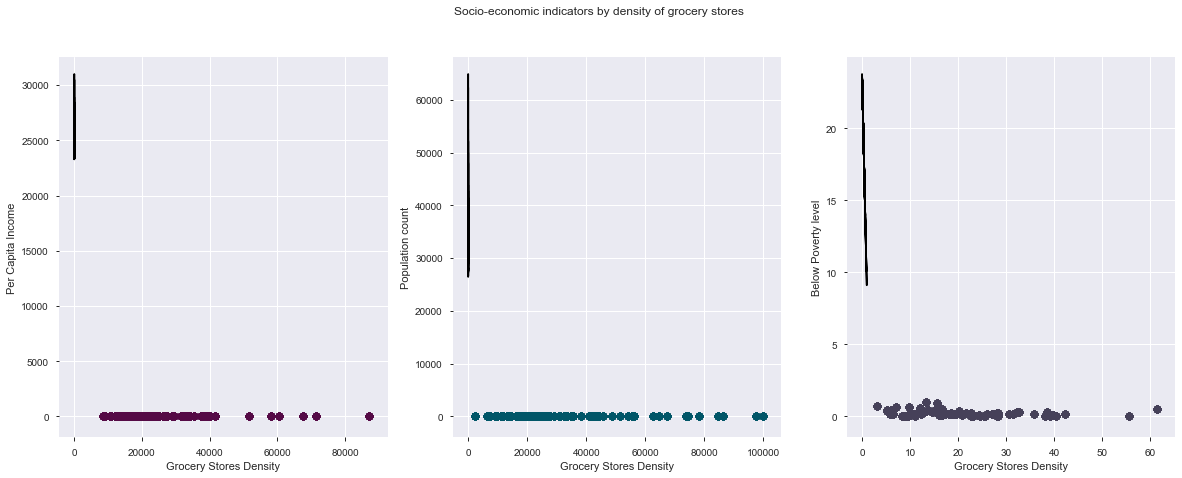

In [23]:
#import plotly
#import plotly.tools as tls
#from plotly.offline import download_plotlyjs, init_notebook_mode, iplot

fig, ax = plt.subplots(1,3, figsize=(20,7))

capita = socioeconomic_factors.sort_values(by='Community Area', ascending=True)
capita = np.array(capita['Per Capita Income'])

poverty = socioeconomic_factors.sort_values(by='Below Poverty Level', ascending=True)
poverty = np.array(poverty['Below Poverty Level'])

population = socioeconomic_factors.sort_values(by='Community Area', ascending=True)
population = np.array(population['Population'])

xs = groceries_intensity.sort_values(by='area_number', ascending=True)
xs = np.array(xs['markets_by_surface'])

labels = groceries_intensity.sort_values(by='area_number', ascending=True)
labels = np.array(labels['Community Area'])


linear_regressor = LinearRegression()  # create object for the class
linear_regressor.fit(xs.reshape(-1,1), capita.reshape(-1,1))  # perform linear regression
y_capita = linear_regressor.predict(xs.reshape(-1,1))  # make predictions
linear_regressor.fit(xs.reshape(-1,1), poverty.reshape(-1,1))  # perform linear regression
y_poverty = linear_regressor.predict(xs.reshape(-1,1))  # make predictions
linear_regressor.fit(xs.reshape(-1,1), population.reshape(-1,1))  # perform linear regression
y_population = linear_regressor.predict(xs.reshape(-1,1))  # make predictions


plt.suptitle('Socio-economic indicators by density of grocery stores')

ax[0].set_xlabel('Grocery Stores Density')
ax[0].set_ylabel('Per Capita Income')
ax[0].plot(xs, y_capita, color='black')

ax[1].set_xlabel('Grocery Stores Density')
ax[1].set_ylabel('Population count')
ax[1].plot(xs, y_population, color='black')

ax[2].set_xlabel('Grocery Stores Density')
ax[2].set_ylabel('Below Poverty level')
ax[2].plot(xs, y_poverty, color='black')
i=0
for x, y in zip(xs,capita):
    ax[0].scatter(xs, capita, color='#550a46')
    i+=1
i=0
for x, y in zip(xs,population):
    ax[1].scatter(xs, population, color='#015668')
    i+=1

i=0
for x, y in zip(xs,poverty):
    ax[2].scatter(xs, poverty, color='#464159')
    i+=1
plt.savefig('grocery_stores.png',transparent=True)

## convert and plot in plotly
#plotly_fig = tls.mpl_to_plotly(fig) ## convert 
#iplot(plotly_fig)
#plotly.offline.plot(plotly_fig, filename='new_indicators.html')

We see that the plots are quite consistent with our research on the subject of food deserts where:
* The higher the population count the higher the Grocery Stores Density.
* The lower Below Poverty level the higher Grocery Stores density.
* The higher the Per Capita Income in a community area, the higher the Grocery Stores Density, the fitted linear regression is not as steep as the others though.

Using our data we can see that grocery stores' density is positively correlated to **Population Count** by community area as well as **Per Capita Income**. It is on the other hand negatively correlated to **Below Poverty Level**. These observations make sense if we think about grocery stores wanting to maximize their profit.

"Grocery stores typically have only 1-2% profit margins, so the difficulties involved in running an urban supermarket are often seen as too costly in an already-risky business." [source](https://en.wikipedia.org/wiki/Supermarket_shortage)

# Data Science for social good

Unequal access to healthy food is a serious problem in nowadays USA. Even though we were not able from our data to explore the problem estensively we got a good first understanding of it.
As for an example of successfully fighting against food deserts, Illinois State could implement the [solution in place in the state of New York](http://www.nyc.gov/html/misc/pdf/fresh_fact_sheet_eng.pdf): "The Food Retail Expansion to Support Health (FRESH) program promotes the establishment and retention of neighborhood grocery stores in underserved communities by providing zoning and financial incentives to eligible grocery store operators
and developers." 